In [71]:
%pip install \
    numpy \
    pandas \
    scipy \
    scikit-learn \
    matplotlib \
    umap-learn \
    optuna \
    hyperopt \
    plotly \
    tensorflow \
    ipywidgets



In [72]:
%load_ext google.colab.data_table
%matplotlib inline


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


Importaciones importantes

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score
)

plt.rcParams['figure.figsize'] = (6,6)


dataset


In [74]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
col_names = [
    'area',
    'perimeter',
    'compactness',              # C = 4*pi*A/P^2
    'kernel_length',            # longitud del grano
    'kernel_width',             # anchura del grano
    'asymmetry_coefficient',    # coeficiente de asimetría
    'groove_length',            # longitud del grano
    'label'                     # clase (Kama 1, Rosa 2 y Canadiense 3)
]

df = pd.read_csv(url, sep='\s+', names=col_names)
df['label'] = df['label'].astype(int)  # 1=Kama,2=Rosa,3=Canadianne
df.head()


area  perimeter  compactness  kernel_length  kernel_width  \
0  15.26      14.84       0.8710          5.763         3.312   
1  14.88      14.57       0.8811          5.554         3.333   
2  14.29      14.09       0.9050          5.291         3.337   
3  13.84      13.94       0.8955          5.324         3.379   
4  16.14      14.99       0.9034          5.658         3.562   

   asymmetry_coefficient  groove_length  label  
0                  2.221          5.220      1  
1                  1.018          4.956      1  
2                  2.699          4.825      1  
3                  2.259          4.805      1  
4                  1.355          5.175      1

pre procesado

In [75]:
X = df.drop('label', axis=1).values
y = df['label'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#calcula la media y desviación estándar


reduc


In [76]:
state=120

pca = PCA(n_components=2, random_state=state)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=state, init='pca')
X_tsne = tsne.fit_transform(X_scaled)

umap = UMAP(n_components=2, random_state=state)
X_umap = umap.fit_transform(X_scaled)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Datos de visualización

In [77]:
def plot_2d(X2d, labels, title):
    for lab in np.unique(labels):
        mask = labels == lab
        plt.scatter(X2d[mask,0], X2d[mask,1], label=f'Clase {lab}', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.show()


visualizacion


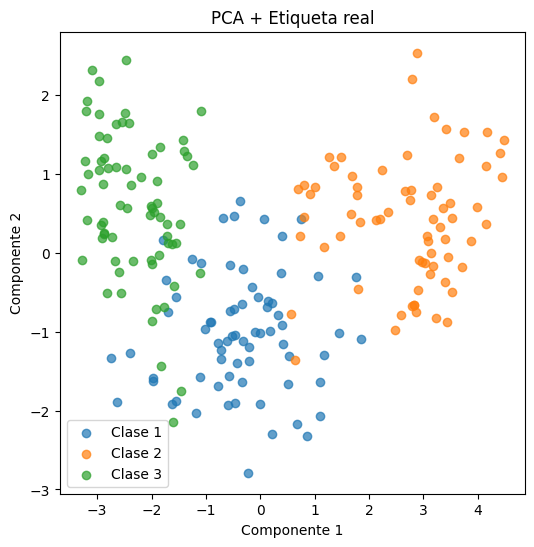

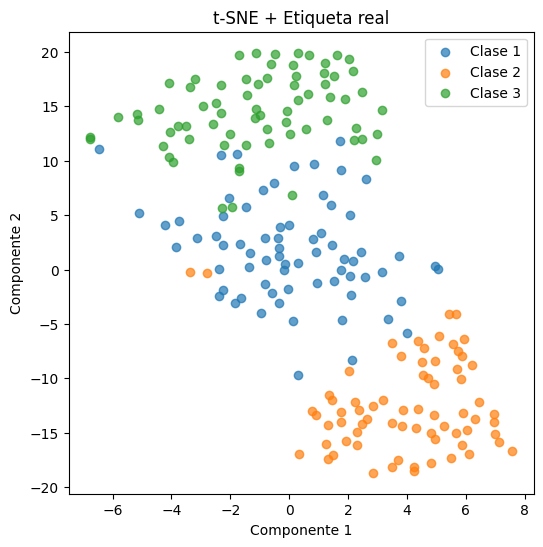

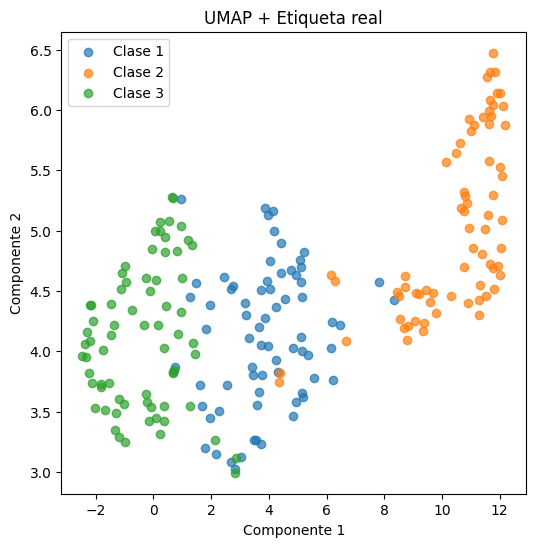

In [78]:
plot_2d(X_pca, y, 'PCA + Etiqueta real')
plot_2d(X_tsne, y, 't-SNE + Etiqueta real')
plot_2d(X_umap, y, 'UMAP + Etiqueta real')


clustering

KMeans (k=3): ARI=0.797, NMI=0.750, Silhouette=0.402


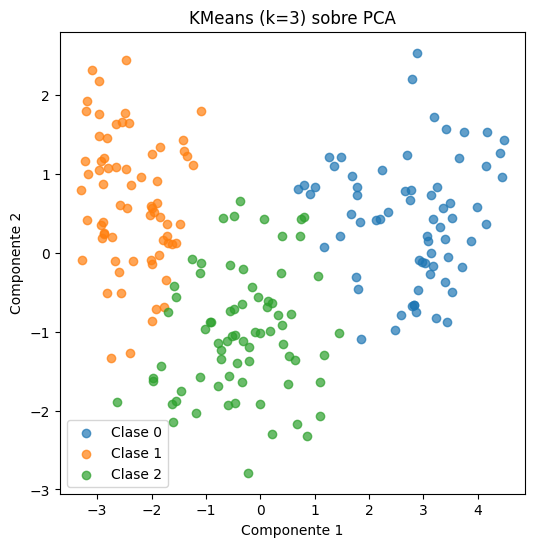

Agglomerative (3): ARI=0.797, NMI=0.750, Silhouette=0.393


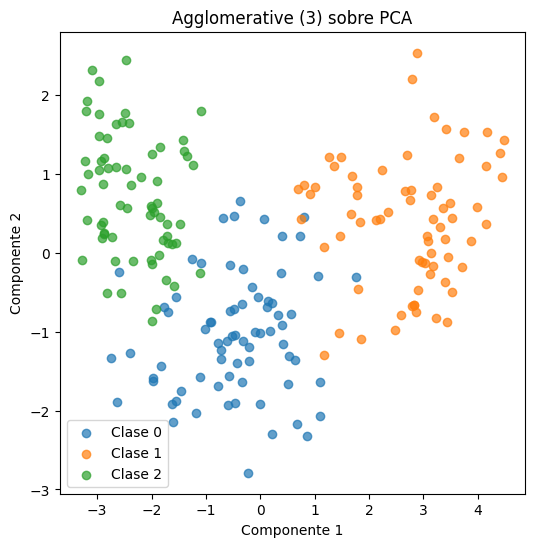

DBSCAN: ARI=0.002, NMI=0.044, Silhouette=0.062


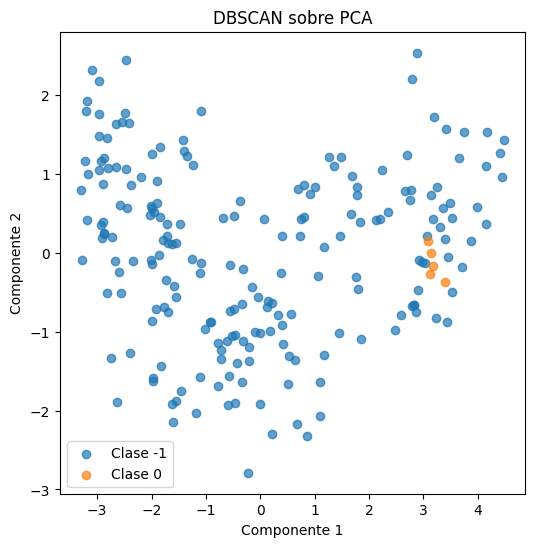

In [79]:
models = {
    'KMeans (k=3)': KMeans(n_clusters=3, random_state=42),
    'Agglomerative (3)': AgglomerativeClustering(n_clusters=3),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
}

for name, model in models.items():
    pred = model.fit_predict(X_scaled)
    ari = adjusted_rand_score(y, pred)
    nmi = normalized_mutual_info_score(y, pred)
    sil = silhouette_score(X_scaled, pred) if len(np.unique(pred))>1 else np.nan
    print(f'{name}: ARI={ari:.3f}, NMI={nmi:.3f}, Silhouette={sil:.3f}')

    # Graficar clusters sobre PCA
    plot_2d(X_pca, pred, f'{name} sobre PCA')


Extra, descarga de variables para analisis


In [80]:
import pandas as pd

results = []
for name, model in models.items():
    pred = model.fit_predict(X_scaled)
    ari = adjusted_rand_score(y, pred)
    nmi = normalized_mutual_info_score(y, pred)
    sil = silhouette_score(X_scaled, pred) if len(np.unique(pred)) > 1 else float('nan')
    results.append({
        'Método': name,
        'ARI': ari,
        'NMI': nmi,
        'Silhouette': sil
    })

df_results = pd.DataFrame(results)
display(df_results)

# Guardar métricas
df_results.to_csv('clustering_metrics.csv', index=False)
print("Métricas exportadas a clustering_metrics.csv")


Método       ARI       NMI  Silhouette
0       KMeans (k=3)  0.797190  0.749895    0.402437
1  Agglomerative (3)  0.796998  0.749816    0.392634
2             DBSCAN  0.001867  0.044162    0.062058

Métricas exportadas a clustering_metrics.csv


In [81]:
# 10) Guardar asignaciones de cluster por instancia
df_assign = df.copy()
for name, model in models.items():
    df_assign[f'Cluster {name}'] = model.fit_predict(X_scaled)

# Mostrar primeras filas
df_assign.head()

# Guardar asignaciones
df_assign.to_csv('cluster_assignments.csv', index=False)
print("Asignaciones exportadas a cluster_assignments.csv")

# Activa el data table de Colab
%load_ext google.colab.data_table

# Después de crear df_assign
df_assign




Asignaciones exportadas a cluster_assignments.csv
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


area  perimeter  compactness  kernel_length  kernel_width  \
0    15.26      14.84       0.8710          5.763         3.312   
1    14.88      14.57       0.8811          5.554         3.333   
2    14.29      14.09       0.9050          5.291         3.337   
3    13.84      13.94       0.8955          5.324         3.379   
4    16.14      14.99       0.9034          5.658         3.562   
..     ...        ...          ...            ...           ...   
205  12.19      13.20       0.8783          5.137         2.981   
206  11.23      12.88       0.8511          5.140         2.795   
207  13.20      13.66       0.8883          5.236         3.232   
208  11.84      13.21       0.8521          5.175         2.836   
209  12.30      13.34       0.8684          5.243         2.974   

     asymmetry_coefficient  groove_length  label  Cluster KMeans (k=3)  \
0                    2.221          5.220      1                     2   
1                    1.018          4.956      1                     2   
2                    2.699          4.825      1                     2   
3                    2.259          4.805      1                     2   
4                    1.355          5.175      1                     2   
..                     ...            ...    ...                   ...   
205                  3.631          4.870      3                     1   
206                  4.325          5.003      3                     1   
207                  8.315          5.056      3                     1   
208                  3.598          5.044      3                     1   
209                  5.637          5.063      3                     1   

     Cluster Agglomerative (3)  Cluster DBSCAN  
0                            0              -1  
1                            0              -1  
2                            0              -1  
3                            0              -1  
4                            0              -1  
..                         ...             ...  
205                          2              -1  
206                          2              -1  
207                          2              -1  
208                          2              -1  
209                          2              -1  

[210 rows x 11 columns]